In [1]:
import os

download_name = "worldcities.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/lectures/p03/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()

name = "worldcities.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))        

In [26]:
import collections
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt

from argparse import Namespace

In [3]:
args = Namespace(
    raw_dataset_csv="worldcities.csv",
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="worldcities_with_splits.csv",
    seed=1337
)

### Read Dataset

👍 Read raw dataset's csv file into pandas DataFrame. Use only `city` and `country` columns.

In [4]:
# Read raw data
cities = pd.read_csv(args.raw_dataset_csv, usecols=["city", "country"])
cities

,city,country
0,Tokyo,Japan
1,Jakarta,Indonesia
2,Delhi,India
3,Manila,Philippines
4,São Paulo,Brazil
...,...,...
42900,Tukchi,Russia
42901,Numto,Russia
42902,Nord,Greenland
42903,Timmiarmiut,Greenland


👍 Count and plot how many datapoints are in each class.

In [5]:
cities.country.value_counts()


United States               7824
Brazil                      3604
Germany                     2643
Italy                       2140
France                      2019
                            ... 
Cook Islands                   1
Grenada                        1
Martinique                     1
Northern Mariana Islands       1
U.S. Virgin Islands            1
Name: country, Length: 239, dtype: int64

<AxesSubplot:ylabel='# cities'>

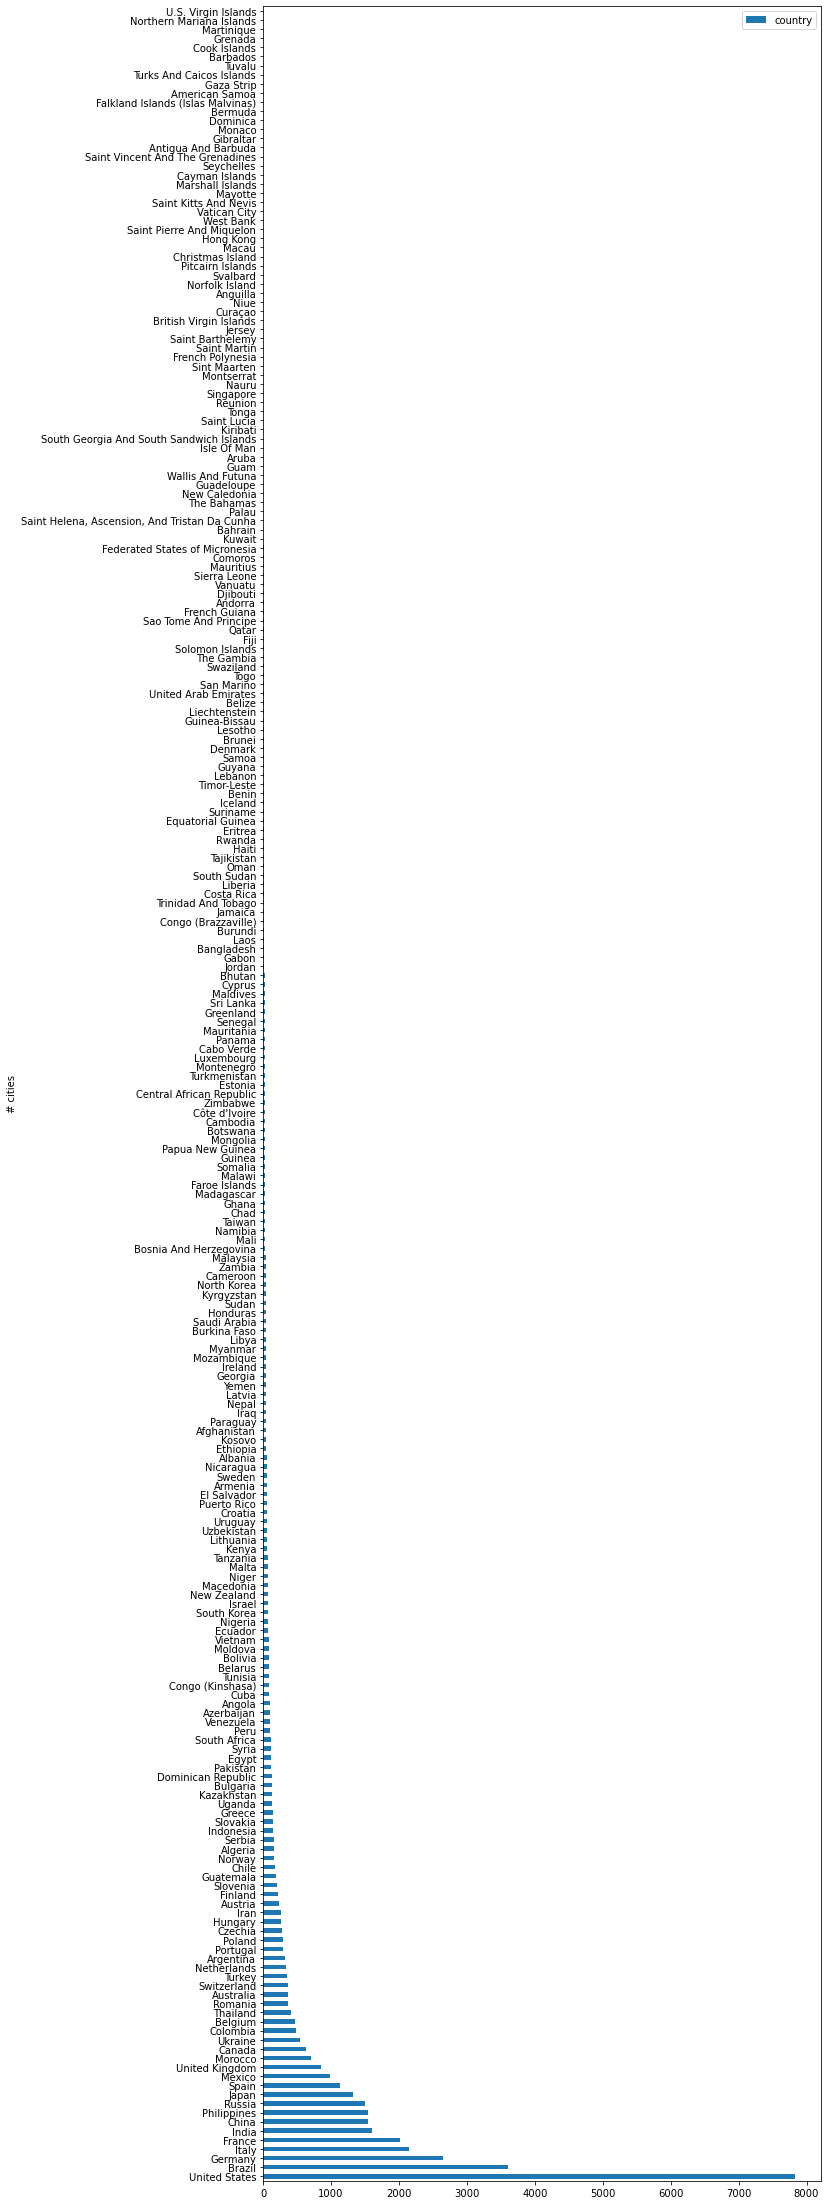

In [39]:
pd.DataFrame(cities.country.value_counts()).plot.barh(xlabel="# cities", figsize=(10, 40))

### Split to TRAIN, VAL, TEST 

👍 For each country that has equal or more than 50 cities make train, val and test split. Use percentages defined in args do determine how many datapoints will be for train, val and test.
Append dataframe with split column.

In [18]:
# Create dict
by_country = collections.defaultdict(list)
for _, row in cities.iterrows():
    by_country[row.country].append(row.to_dict())


cutoff = 50
for country in list(by_country):
    n_cities = len(by_country[country])
    if  n_cities < cutoff:
        by_country.pop(country)
        print(f"removed {country} ({n_cities})")

removed Bangladesh (19)
removed Malaysia (35)
removed Hong Kong (1)
removed Saudi Arabia (40)
removed Iraq (44)
removed Sudan (39)
removed Myanmar (41)
removed Singapore (1)
removed Côte d'Ivoire (26)
removed Afghanistan (45)
removed Jordan (19)
removed Ethiopia (47)
removed Kuwait (4)
removed Yemen (42)
removed North Korea (37)
removed Taiwan (32)
removed Madagascar (29)
removed United Arab Emirates (9)
removed Burkina Faso (40)
removed Cameroon (36)
removed Ghana (30)
removed Zimbabwe (26)
removed Cambodia (27)
removed Somalia (29)
removed Mali (33)
removed Malawi (29)
removed Congo (Brazzaville) (18)
removed Zambia (35)
removed Guinea (29)
removed Oman (16)
removed Mongolia (27)
removed Honduras (39)
removed Mozambique (41)
removed Qatar (8)
removed Senegal (22)
removed Rwanda (15)
removed Libya (41)
removed Georgia (41)
removed Chad (30)
removed Denmark (12)
removed Mauritania (22)
removed Kyrgyzstan (38)
removed Nepal (43)
removed Liberia (17)
removed Haiti (15)
removed Eritrea (1

In [19]:
# Create split data
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_country.items()):
    np.random.shuffle(item_list)
    n = len(item_list)
    n_train = int(args.train_proportion*n)
    n_val = int(args.val_proportion*n)
    n_test = int(args.test_proportion*n)
    
    # Give data point a split attribute
    for item in item_list[:n_train]:
        item['split'] = 'train'
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
    for item in item_list[n_train+n_val:]:
        item['split'] = 'test'  
    
    # Add to final list
    final_list.extend(item_list)

In [20]:
# Write split data to file
final_cities = pd.DataFrame(final_list)

### Save dataset

👍 Save DataFrame with header into comma separated file defined by arguments.

In [21]:
final_cities.split.value_counts()

train    28337
test      6163
val       6041
Name: split, dtype: int64

In [22]:
final_cities.head()

,city,country,split
0,Tirana,Albania,train
1,Peshkopi,Albania,train
2,Ballsh,Albania,train
3,Shkodër,Albania,train
4,Pogradec,Albania,train


In [23]:
# Write munged data to CSV
final_cities.to_csv(args.output_munged_csv, index=False)

<AxesSubplot:ylabel='# cities'>

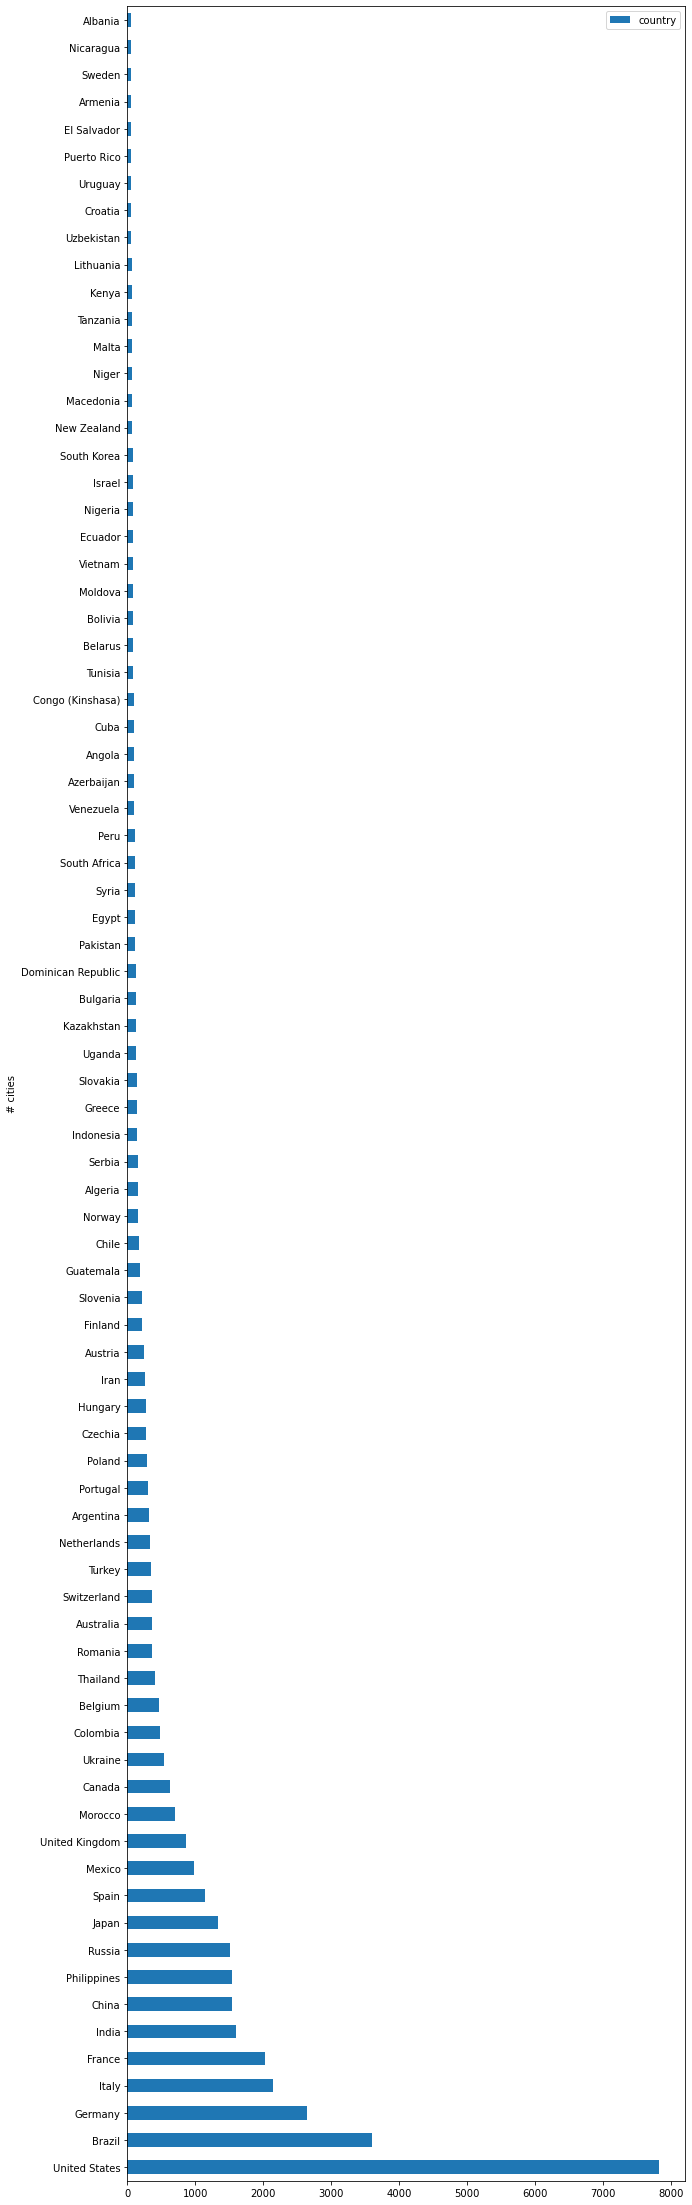

In [40]:
pd.DataFrame(final_cities.country.value_counts()).plot.barh(xlabel="# cities", figsize=(10, 40))

# Weighting classes by frequencies

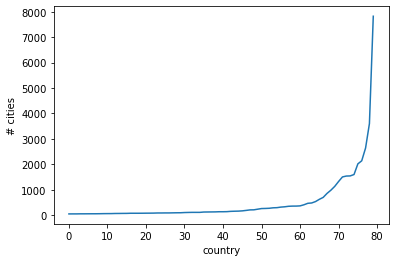

In [62]:
freqs = np.array(sorted(final_cities.country.value_counts().to_dict().values()))

plt.xlabel("country")
plt.ylabel("# cities")
plt.plot(freqs)
plt.show()

### Standard weighting

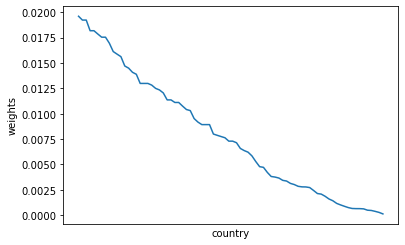

In [81]:
weights = 1 / freqs

plt.xticks([])
plt.xlabel("country")
plt.ylabel("weights")
plt.plot(weights)
plt.show()


### Log weighting

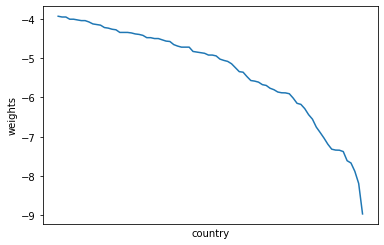

In [80]:


weights = np.log(1/freqs)


plt.xticks([])
plt.xlabel("country")
plt.ylabel("weights")
plt.plot(weights)
plt.show()
